In [1]:
import boto3
import sagemaker
import pandas as pd
from sagemaker import get_execution_role
from sagemaker.estimator import Estimator

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [2]:
bucket_name = "roshanhousepricebucket"
my_region = boto3.session.Session().region_name
print(my_region)

ap-south-1


In [3]:
s3 = boto3.resource('s3')
try:
    if my_region == 'ap-south-1':
        s3.create_bucket(Bucket=bucket_name, CreateBucketConfiguration={'LocationConstraint': 'ap-south-1'})
    print('S3 bucket created successfully')
except Exception as e:
    print('S3 error: ', e)

S3 bucket created successfully


In [4]:
# set an output path where the trained model will be saved
prefix = 'xgboost-as-a-built-in-algo'
output_path ='s3://{}/{}/output'.format(bucket_name, prefix)
print(output_path)

s3://roshanhousepricebucket/xgboost-as-a-built-in-algo/output


In [5]:
csv_file = 'BostonHousing.csv'  

try:
    house_data = pd.read_csv(csv_file)
    print('Success: Data loaded into dataframe.')
except Exception as e:
    print('Data load error: ', e)

Success: Data loaded into dataframe.


In [6]:
house_data.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [7]:
house_data.rename(columns={'medv':'price'}, inplace=True)

In [8]:
house_data.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,price
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [9]:
house_data.shape

(506, 14)

In [11]:
house_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   crim     506 non-null    float64
 1   zn       506 non-null    float64
 2   indus    506 non-null    float64
 3   chas     506 non-null    int64  
 4   nox      506 non-null    float64
 5   rm       506 non-null    float64
 6   age      506 non-null    float64
 7   dis      506 non-null    float64
 8   rad      506 non-null    int64  
 9   tax      506 non-null    int64  
 10  ptratio  506 non-null    float64
 11  b        506 non-null    float64
 12  lstat    506 non-null    float64
 13  price    506 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 55.5 KB


In [13]:
house_data.describe()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,price
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [14]:
house_data.isnull().sum()

crim       0
zn         0
indus      0
chas       0
nox        0
rm         0
age        0
dis        0
rad        0
tax        0
ptratio    0
b          0
lstat      0
price      0
dtype: int64

In [19]:
#Correlation between the features in dataset
import matplotlib.pyplot as plt
import seaborn as sns

correlation = house_data.corr()

<Axes: >

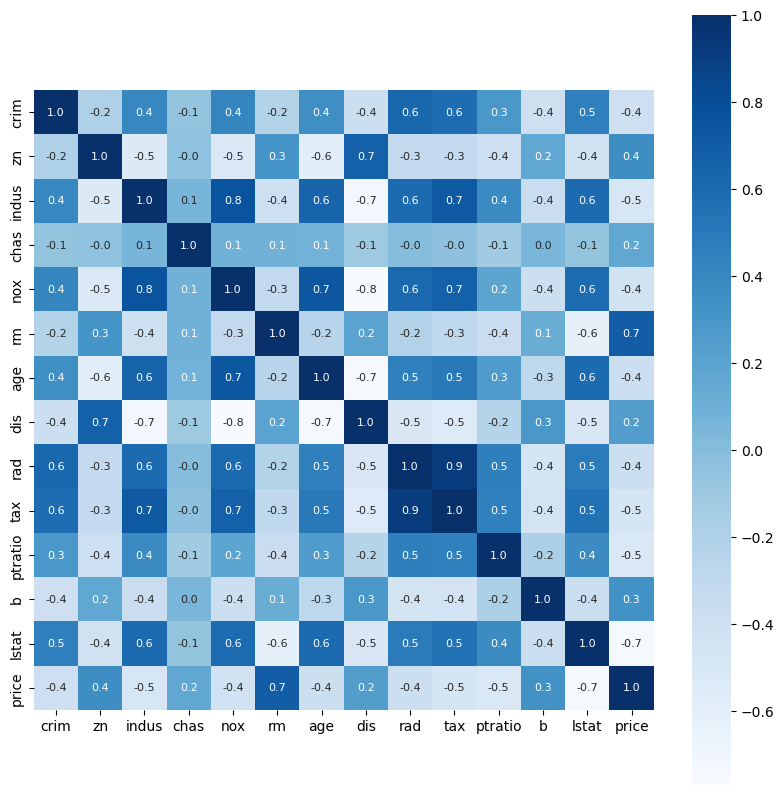

In [20]:
#heatmap for understanding correlation
plt.figure(figsize=(10,10))
sns.heatmap(correlation, cbar=True, square=True, fmt='.1f', annot=True, annot_kws={'size':8}, cmap='Blues')

In [21]:
### Train Test split

import numpy as np
train_data, test_data = np.split(house_data.sample(frac=1, random_state=1729), [int(0.7 * len(house_data))])
print(train_data.shape, test_data.shape)

(354, 14) (152, 14)


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [24]:
### Saving Train And Test Into Buckets
## We start with Train Data
import os
from sagemaker.inputs import TrainingInput

pd.concat([train_data['price'], train_data.drop(['price'], 
                                                axis=1)], 
                                                axis=1).to_csv('train.csv', index=False, header=False)
boto3.Session().resource('s3').Bucket(bucket_name).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
s3_input_train = TrainingInput(s3_data='s3://{}/{}/train'.format(bucket_name, prefix), content_type='csv')

In [25]:
# Test Data Into Buckets
pd.concat([test_data['price'], test_data.drop(['price'], axis=1)], axis=1).to_csv('test.csv', index=False, header=False)
boto3.Session().resource('s3').Bucket(bucket_name).Object(os.path.join(prefix, 'test/test.csv')).upload_file('test.csv')
s3_input_test = TrainingInput(s3_data='s3://{}/{}/test'.format(bucket_name, prefix), content_type='csv')

In [36]:
#MODEL TRAINING

# XGBoost
from sagemaker import image_uris

container = image_uris.retrieve('xgboost', boto3.Session().region_name, version='1.0-1')

role = get_execution_role()

estimator = sagemaker.estimator.Estimator(image_uri=container, 
                                          hyperparameters=hyperparameters,
                                          role=sagemaker.get_execution_role(),
                                          train_instance_count=1, 
                                          train_instance_type='ml.m5.2xlarge', 
                                          train_volume_size=5, # 5 GB 
                                          output_path=output_path,
                                          train_use_spot_instances=True,
                                          train_max_run=300,
                                          train_max_wait=600) 

INFO:sagemaker.image_uris:Defaulting to only available Python version: py3
INFO:sagemaker.image_uris:Defaulting to only supported image scope: cpu.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [37]:
# Set hyperparameters for the model
# initialize hyperparameters
hyperparameters = {
        "max_depth":"5",
        "eta":"0.2",
        "gamma":"4",
        "min_child_weight":"6",
        "subsample":"0.7",
        "objective":"binary:logistic",
        "num_round":50
        }

In [38]:
# Train the model
estimator.fit({'train': s3_input_train,'validation': s3_input_test})

INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2024-08-20-05-19-26-740


2024-08-20 05:19:26 Starting - Starting the training job...
2024-08-20 05:19:43 Starting - Preparing the instances for training...
2024-08-20 05:20:25 Downloading - Downloading the training image...
2024-08-20 05:20:56 Training - Training image download completed. Training in progress....
2024-08-20 05:21:21 Uploading - Uploading generated training model[2024-08-20 05:21:13.397 ip-10-0-91-58.ap-south-1.compute.internal:7 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value reg:squarederror to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
I

In [39]:
#Deploy Machine Learning Model As Endpoints

predictor = estimator.deploy(initial_instance_count=1, instance_type='ml.m5.large')

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2024-08-20-05-22-08-393
INFO:sagemaker:Creating endpoint-config with name sagemaker-xgboost-2024-08-20-05-22-08-393
INFO:sagemaker:Creating endpoint with name sagemaker-xgboost-2024-08-20-05-22-08-393


------!

In [40]:
#Prediction of the Test Data

from sagemaker.serializers import CSVSerializer

test_data_array = test_data.drop(['price'], axis=1).values  # Load the data into an array
predictor.content_type = 'text/csv'  # Set the data type for an inference
predictor.serializer = CSVSerializer()  # Set the serializer type
predictions = predictor.predict(test_data_array).decode('utf-8')  # Predict!
predictions_array = np.fromstring(predictions[1:], sep=',')  # Convert the prediction into an array
print(predictions_array.shape)

(152,)


In [41]:
predictions_array

array([ 6.47598076, 22.48883057, 36.14986038, 12.91119766, 21.32283592,
       25.74852371, 30.27306175, 16.20602417, 18.81606865, 20.59030151,
       21.44624901, 33.64437485, 16.1995182 , 18.36657715, 25.24765778,
       32.29356766, 22.22002983, 27.05437279, 17.96055031,  8.73984528,
       22.93794632, 30.51756859, 28.62881851, 15.63776779, 36.37384415,
       19.12374115, 16.22221756, 22.35783386, 15.70823097, 36.98379898,
       25.18732452, 24.80260277, 42.86718369, 23.4444561 , 26.57649422,
       29.24414062, 19.79018593, 20.4646244 , 28.91113663, 14.22143364,
       17.7162571 , 18.9941082 , 21.12211609, 31.26916504, 29.83444405,
       15.38547134, 25.56599998, 14.11057758, 23.51238632, 27.40533066,
       24.2046814 , 30.76434326, 20.04627609, 39.35706329, 21.5482254 ,
       21.27949715,  8.11036491, 20.14955139, 20.55923462, 25.60066795,
       19.14931488, 19.81839943, 42.45933533, 25.50443268, 19.13569641,
       19.0952282 , 37.18432617, 18.77037811, 21.39943695, 21.01

In [42]:
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(test_data['price'], predictions_array)
r2 = r2_score(test_data['price'], predictions_array)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 13.325073303247102
R-squared: 0.8146244640663785


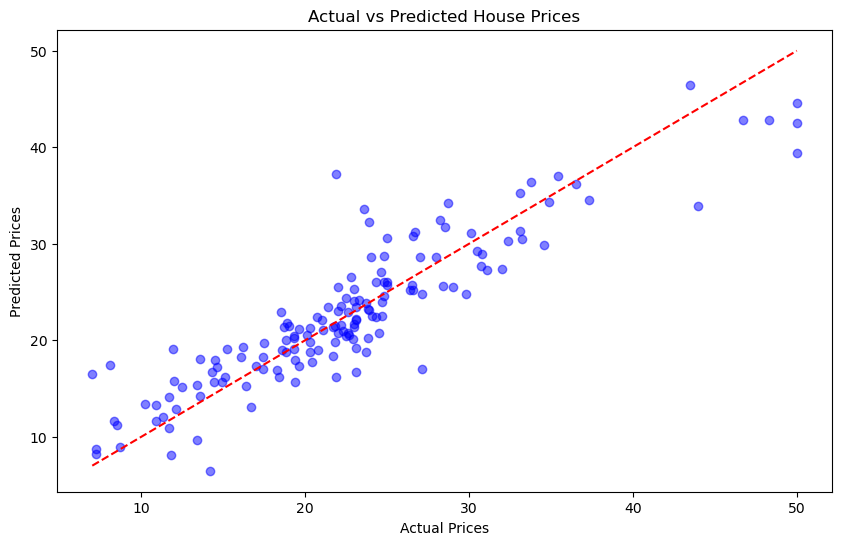

In [43]:
# Scatter plot of Actual vs Predicted prices
plt.figure(figsize=(10, 6))
plt.scatter(test_data['price'], predictions_array, color='blue', alpha=0.5)
plt.plot([min(test_data['price']), max(test_data['price'])], [min(test_data['price']), max(test_data['price'])], color='red', linestyle='--')
plt.title('Actual vs Predicted House Prices')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.show()

In [45]:
# Deleting The Endpoints

sagemaker.Session().delete_endpoint(predictor.endpoint)
bucket_to_delete = boto3.resource('s3').Bucket(bucket_name)
bucket_to_delete.objects.all().delete()  

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
INFO:sagemaker:Deleting endpoint with name: sagemaker-xgboost-2024-08-20-05-22-08-393


[{'ResponseMetadata': {'RequestId': '3EQT010SE0DJ9S3V',
   'HostId': 'MN06KFL5LlU3rff9APaHwlyV86p/KY2SelWX7nMBxrTP4x75cw09V5U11LkUyLqDsigPFaof2JGBvsN4CGyYRA==',
   'HTTPStatusCode': 200,
   'HTTPHeaders': {'x-amz-id-2': 'MN06KFL5LlU3rff9APaHwlyV86p/KY2SelWX7nMBxrTP4x75cw09V5U11LkUyLqDsigPFaof2JGBvsN4CGyYRA==',
    'x-amz-request-id': '3EQT010SE0DJ9S3V',
    'date': 'Tue, 20 Aug 2024 05:31:01 GMT',
    'content-type': 'application/xml',
    'transfer-encoding': 'chunked',
    'server': 'AmazonS3',
    'connection': 'close'},
   'RetryAttempts': 0},
  'Deleted': [{'Key': 'xgboost-as-a-built-in-algo/output/sagemaker-xgboost-2024-08-20-05-19-26-740/debug-output/events/000000000000/000000000000_worker_0.tfevents'},
   {'Key': 'xgboost-as-a-built-in-algo/output/sagemaker-xgboost-2024-08-20-05-19-26-740/profiler-output/system/incremental/2024082005/1724131200.algo-1.json'},
   {'Key': 'xgboost-as-a-built-in-algo/train/train.csv'},
   {'Key': 'xgboost-as-a-built-in-algo/output/sagemaker-xgboos